In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
import matplotlib.patheffects as path_effects
from matplotlib.font_manager import FontProperties
from matplotlib.patches import FancyArrowPatch

df = pd.read_csv('Global Ecological Footprint 2023.csv', encoding='latin-1')
df.replace(' ', None, inplace=True)
df = df[[
   'Life Exectancy',
   'Country',
   'Region',
   'Per Capita GDP',
   'Population (millions)',
   'Total Ecological Footprint (Consumption)',
   'Total biocapacity ',
   'Ecological (Deficit) or Reserve',
   'Number of Earths required'
]]
df.columns = [
   'lifexp',
   'country',
   'region',
   'gdpCapita',
   'populationMillions',
   'footprint',
   'biocapacity',
   'ecoReserve',
   'earthsRequired'
]
df['gdpCapita'] = df['gdpCapita'].str.replace('$', '').str.replace(',', '').astype(float)
df['populationMillions'] = df['populationMillions'].str.replace(',', '').astype(float)
df['lifexp'] = df['lifexp'].astype(float)
df['biocapacity'] = df['biocapacity'].astype(float)
df = df[df['biocapacity'] >= 1]
df['ratio'] = df['footprint'] / df['biocapacity']

print(df.shape)
df.to_csv('data_cleaned.csv', index=False)
df.head()

(114, 10)


,lifexp,country,region,gdpCapita,populationMillions,footprint,biocapacity,ecoReserve,earthsRequired,ratio
1,76.0,Albania,Other Europe,14889.0,2.9,2.1,1.176752,-0.894486,1.371485,1.784573
3,62.0,Angola,Africa,6304.0,35.0,0.9,1.588191,0.730346,0.568029,0.566682
5,75.0,Argentina,South America,22117.0,46.0,3.2,5.231663,2.011045,2.132556,0.611660
7,83.0,Australia,Asia-Pacific,53053.0,26.1,5.8,11.021401,5.244362,3.825307,0.526249
8,81.0,Austria,EU-27,55460.0,9.1,5.6,2.893775,-2.732866,3.725721,1.935189


In [113]:
def create_gradient_colormap(colors):
   cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)
   return cmap

def path_effect_stroke(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

def draw_arrow(
   fig, tail_position, head_position,
   color='black', lw=1, radius=0.1, tail_width=0.01,
   head_width=5, head_length=5, invert=False,
   **kwargs):
   arrow_style = f"Simple, tail_width={tail_width}, head_width={head_width}, head_length={head_length}"
   connection_style = f"arc3,rad={'-' if invert else ''}{radius}"
   arrow_patch = FancyArrowPatch(
      tail_position,
      head_position,
      connectionstyle=connection_style,
      transform=fig.transFigure,
      arrowstyle=arrow_style,
      color=color,
      lw=lw,
      **kwargs,
   )
   fig.patches.append(arrow_patch)

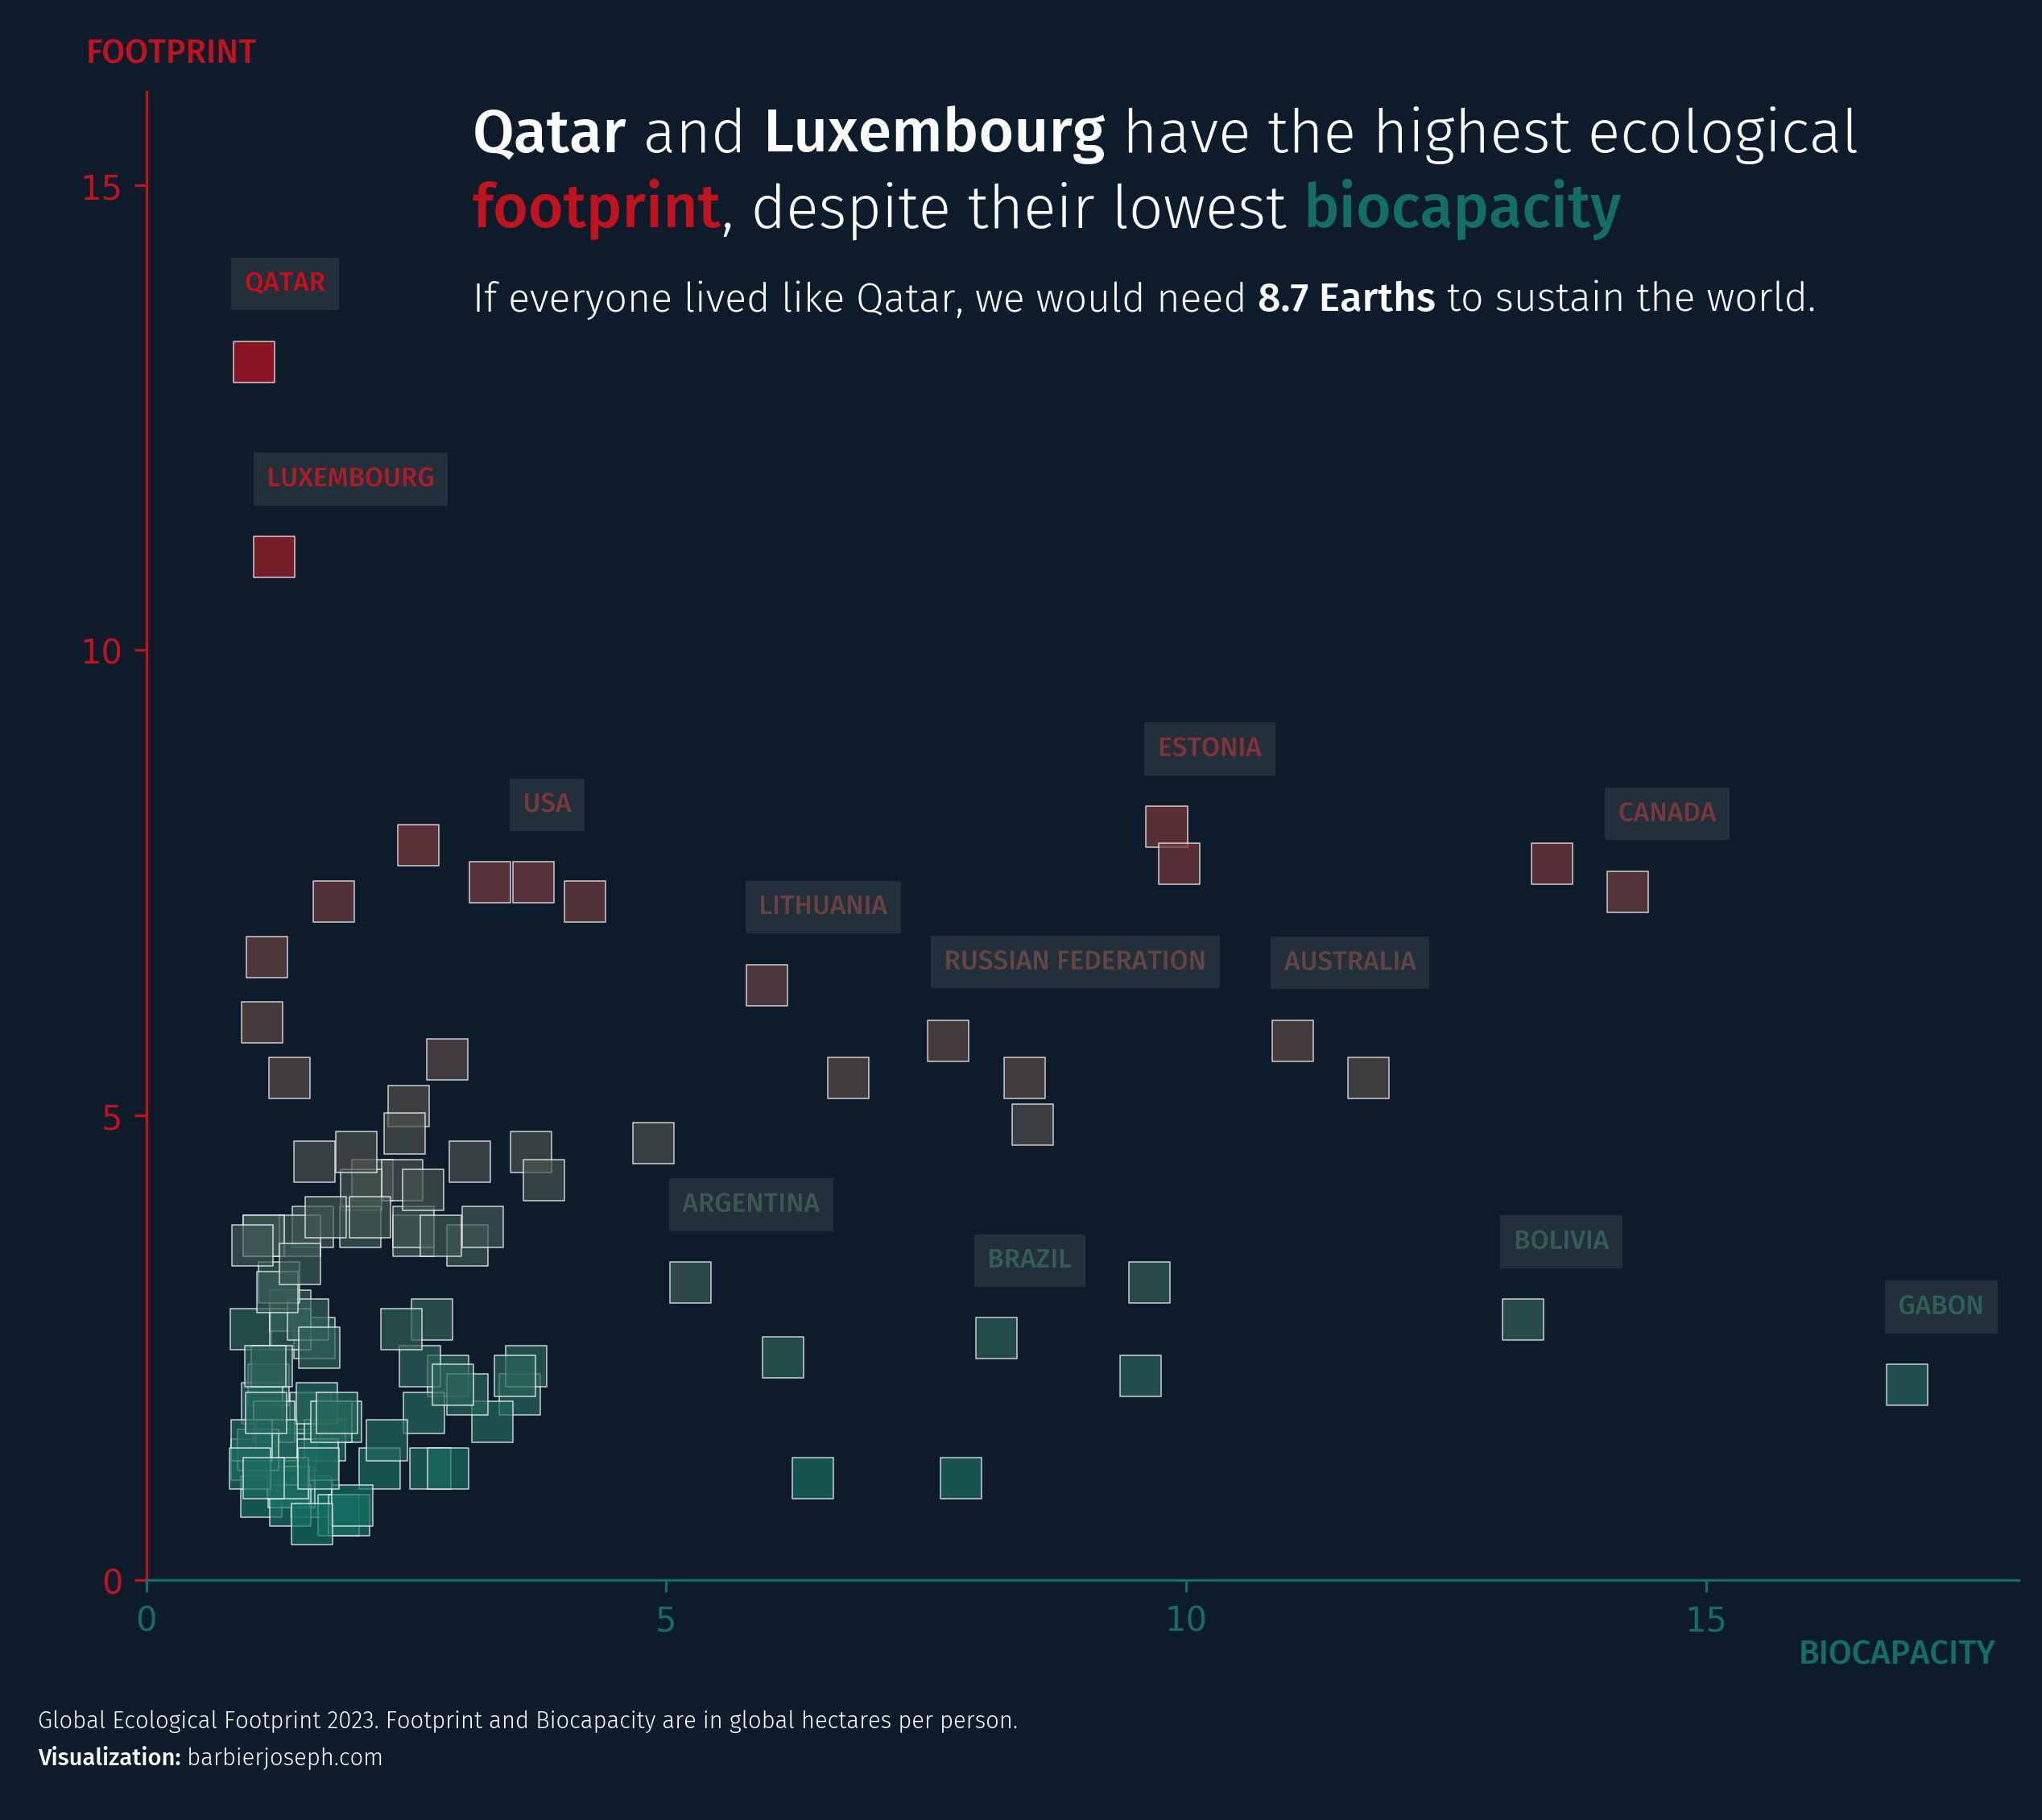

In [119]:
data = df.copy()
high_biocapacity = data[data['biocapacity'] >= 60]
data = data[data['biocapacity']< 60]

# parameters
colors = ['#136f63', '#db3a34']
colors = ['#136f63', '#c1121f']
cmap = create_gradient_colormap(colors)
background_color = '#0d1b2a'
text_color = 'white'
light_text_color = '#6c757d'
pe = path_effect_stroke(linewidth=0.1, foreground=background_color)
countries_to_annote = [
   'Australia', 'Bolivia', 'Canada',
   'Gabon', 'Brazil', 'Argentina',
   'Estonia', 'Luxembourg', 'Qatar',
   'United States of America',
   'Lithuania', 'Russian Federation',
]
x_col = 'biocapacity'
y_col = 'footprint'
c = 'earthsRequired'

# font
personal_path = '/Users/josephbarbier/Library/Fonts/'
font_path = personal_path + 'FiraSans-Light.ttf'
font = FontProperties(fname=font_path)
bold_font = FontProperties(fname=personal_path + 'FiraSans-Medium.ttf')

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.spines[['top', 'right']].set_visible(False)
ax.spines['bottom'].set_color(colors[0])
ax.spines['left'].set_color(colors[1])
ax.tick_params(axis='x', colors=colors[0])
ax.tick_params(axis='y', colors=colors[1])
ax.set_xticks([0, 5, 10, 15])
ax.set_yticks([0, 5, 10, 15])
ax.set_xlim(0, 18)
ax.set_ylim(0, 16)

scatter = ax.scatter(
   data[x_col],
   data[y_col],
   c=data[c],
   s=150,
   cmap=cmap,
   edgecolor='white',
   alpha=0.7,
   marker='s',
   linewidth=0.4
)

labels = []
for country in countries_to_annote:
   x = data.loc[data['country'] == country, x_col].values[0]
   y = data.loc[data['country'] == country, y_col].values[0]
   color = cmap(data.loc[data['country'] == country, c].values[0]/data[c].max())
   if country == 'United States of America':
      country = 'USA'
   text = ax.text(
      x-0.11,
      y+1,
      country.upper(),
      fontsize=8,
      font=bold_font,
      color=color,
      path_effects=pe,
      ha='left',
      va='top',
      zorder=10,
      bbox=dict(facecolor='grey', edgecolor='none', alpha=0.2)
   )
   labels.append(text)

adjust_text(
   labels,
   ax=ax
)

# title
qatar_color = cmap(data.loc[data['country'] == 'Qatar', c].values[0]/data[c].max())
luxembourg_color = cmap(data.loc[data['country'] == 'Luxembourg', c].values[0]/data[c].max())
qatar_earths = data.loc[data['country'] == 'Qatar', 'earthsRequired'].values[0]
luxembourg_earths = data.loc[data['country'] == 'Luxembourg', 'earthsRequired'].values[0]
text = f"""
<Qatar> and <Luxembourg> have the highest ecological\n<footprint>, despite their lowest <biocapacity>
"""
fig_text(
   0.26,
   0.88,
   text,
   fontsize=18,
   color=text_color,
   font=font,
   ha='left',
   va='top',
   highlight_textprops=[
      {'font':bold_font},
      {'font':bold_font},
      {'font':bold_font, 'color':colors[1]},
      {'font':bold_font, 'color':colors[0]}
   ],
   ax=ax
)
text = f"""
If everyone lived like Qatar, we would need <{qatar_earths:.1f} Earths> to sustain the world.
"""
fig_text(
   0.26,
   0.79,
   text,
   fontsize=12,
   color=text_color,
   font=font,
   ha='left',
   va='top',
   highlight_textprops=[
      {'font':bold_font}
   ],
   ax=ax
)

# credit and about
text = """
Global Ecological Footprint 2023. Footprint and Biocapacity are in global hectares per person.
<Visualization:> barbierjoseph.com
"""
fig_text(
   0.08,
   0.05,
   text,
   fontsize=7,
   font=font,
   color=text_color,
   ha='left',
   va='top',
   highlight_textprops=[
      {'font':bold_font}
   ],
   ax=ax
)

# label for axis
fig_text(
   0.85, 0.08,
   'Biocapacity'.upper(),
   fontsize=10,
   font=bold_font,
   color=colors[0],
   ha='center',
   va='top',
   ax=ax
)
fig_text(
   0.1, 0.9,
   'Footprint'.upper(),
   fontsize=10,
   font=bold_font,
   color=colors[1],
   ha='left',
   va='center',
   ax=ax
)

# arows for the scales
#draw_arrow(fig, (0.4, 0.6), (0.4, 0.9), color=text_color, radius=0, head_width=8, head_length=8)
#draw_arrow(fig, (0.31, 0.74), (0.51, 0.74), color=text_color, radius=0, head_width=8, head_length=8)

plt.savefig('scatterplot.png', bbox_inches='tight', dpi=300)
plt.show()

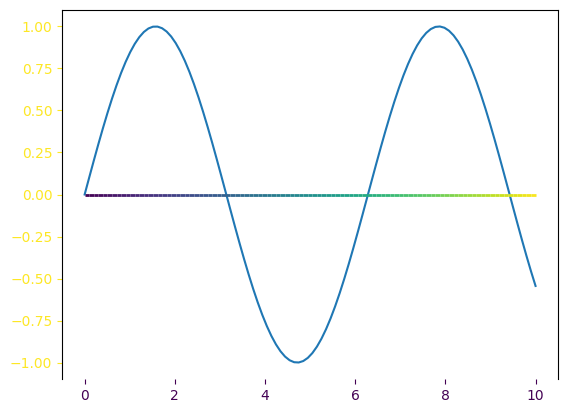

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(x)
ax.plot(x, y)

# Select a colormap
cmap = plt.cm.viridis

# Generate gradient segments
segments = np.array([[[x[i], 0], [x[i+1], 0]] for i in range(len(x)-1)])
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(x)
lc.set_linewidth(2)

# Add the gradient line collection to the axis
ax.add_collection(lc)

# Remove the existing bottom spine
ax.spines['bottom'].set_visible(False)

# Set the tick parameters to match the color at the ends of the gradient
ax.tick_params(axis='x', colors=cmap(0.0))
ax.tick_params(axis='y', colors=cmap(1.0))

# Display the plot
plt.show()
